# Mateusz Kucharz - Machine Learning Project

## About project

## EDA

Importing libraries

In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report,make_scorer

Additional functions

In [139]:

def num_density(data, var_names):
    num_vars = len(var_names)
    rows = (num_vars // 3) + (num_vars % 3 > 0)  
    cols = min(3, num_vars)  

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)
    axes = axes.flatten()

    for i, var in enumerate(var_names):
        if var in ["Number of Promotions","Number of Dependents"]:
            sns.histplot(data=data, x=var, hue='Attrition', kde=False, stat='density', common_norm=False, discrete=True,
                         alpha=0.5, ax=axes[i]) 
            axes[i].set_title(f"Histogram of {var} vs. Attrition")
        else:
            sns.kdeplot(data=data, x=var, hue='Attrition', fill=True, common_norm=False, alpha=0.5, ax=axes[i])
            axes[i].set_title(f"Density of {var} vs. Attrition")
        
        axes[i].set_xlabel(var)
        axes[i].set_ylabel("Density")

    for ax in axes[num_vars:]:
        ax.remove()

    plt.show()

def cat_contingency(data,var_names):
    num_vars = len(var_names)
    rows = (num_vars // 3) + (num_vars % 3 > 0)  
    cols = min(3, num_vars)  

    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5), constrained_layout=True)
    axes = axes.flatten()
    colors = ['#ff7f0e','#1f77b4'] 

    for i, var in enumerate(var_names):
        contingency_table = pd.crosstab(data[var], data['Attrition'])
        contingency_table.div(contingency_table.sum(1), axis=0).plot(kind='bar', stacked=True, ax=axes[i], color=colors)
        axes[i].set_title(f"Count {var} vs. Attrition")
        axes[i].set_ylabel("Proportions")
        axes[i].set_xlabel(var)


    for ax in axes[num_vars:]:
        ax.remove()

    plt.show()

def num_distribution(data, var_names):
    num_vars = len(var_names)
    rows = num_vars // 2 + num_vars % 2  
    cols = 2  

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)
    axes = axes.flatten()

    for i, var in enumerate(var_names):
        if var in ["Number of Promotions","Number of Dependents"]:
            sns.histplot(data=data, x=var, discrete=True, ax=axes[i])
        else:
            sns.histplot(data=data, x=var, ax=axes[i])
        
        axes[i].set_title(f"Distribution of {var}")
        axes[i].set_xlabel(var)
    for ax in axes[num_vars:]:
        ax.remove()

    plt.show()

def cat_counts(data, categorical_vars):
    """
    Tworzy siatkę wykresów słupkowych dla zmiennych kategorycznych,
    pokazując liczności poszczególnych kategorii.

    Parameters:
        data (pd.DataFrame): DataFrame zawierający dane.
        categorical_vars (list): Lista zmiennych kategorycznych.
    """

    num_vars = len(categorical_vars)
    rows = (num_vars // 3) + (num_vars % 3 > 0)  
    cols = min(3, num_vars)  

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)
    axes = axes.flatten()

    for i, var in enumerate(categorical_vars):
        sns.countplot(data=data, x=var, ax=axes[i], hue=var, palette="Set2", legend=False)
        axes[i].set_title(f"Counts for {var}")
        axes[i].set_xlabel(var)
        axes[i].set_ylabel("Count")
        axes[i].tick_params(axis='x', rotation=45)


    for ax in axes[num_vars:]:
        ax.remove()

    plt.show()

def remove_outliers_from_numerical(df, columns, contamination=0.01):

    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    outliers = iso_forest.fit_predict(df[columns])
    normal_indices = df.index[outliers != -1]
    return df.loc[normal_indices]

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)


def custom_score(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = specificity_score(y_true, y_pred)

    return 0.5 * accuracy + 0.25 * recall + 0.25 * specificity

def show_metrics(y_test,y_pred,values = False):
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print("Recall", report['1']['recall'])
    print("Specificity:", report['0']['recall'])
    print("Accuracy:", report['accuracy'])
    if values:
        return report['accuracy'],report['0']['recall'],report['1']['recall']
    else:
        return

def roc_plot(y_test,y_proba):
    
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    # 3. Oblicz wartość AUC
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.3f}")

    # 4. Narysuj krzywą ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title('ROC Curve', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()


warnings.simplefilter(action='ignore', category=FutureWarning)

### Variables


- **Employee ID**: A unique identifier assigned to each employee.
- **Age**: The age of the employee, ranging from 18 to 60 years.
- **Gender**: The gender of the employee
- **Years at Company**: The number of years the employee has been working at the company.
- **Monthly Income**: The monthly salary of the employee, in dollars.
- **Job Role**: The department or role the employee works in, encoded into categories such as Finance, Healthcare, Technology, Education, and Media.
- **Work-Life Balance**: The employee's perceived balance between work and personal life, (Poor, Below Average, Good, Excellent)
- **Job Satisfaction**: The employee's satisfaction with their job: (Very Low, Low, Medium, High)
- **Performance Rating**: The employee's performance rating: (Low, Below Average, Average, High)
- **Number of Promotions**: The total number of promotions the employee has received.
- **Distance from Home**: The distance between the employee's home and workplace, in miles.
- **Education Level**: The highest education level attained by the employee: (High School, Associate Degree, Bachelor’s Degree, Master’s Degree, PhD)
- **Marital Status**: The marital status of the employee: (Divorced, Married, Single)
- **Job Level**: The job level of the employee: (Entry, Mid, Senior)
- **Company Size**: The size of the company the employee works for: (Small,Medium,Large)
- **Company Tenure**: The total number of years the employee's company has been in the industry.
- **Remote Work**: Whether the employee works remotely: (Yes or No)
- **Leadership Opportunities**: Whether the employee has leadership opportunities: (Yes or No)
- **Innovation Opportunities**: Whether the employee has opportunities for innovation: (Yes or No)
- **Company Reputation**: The employee's perception of the company's reputation: (Very Poor, Poor,Good, Excellent)
- **Employee Recognition**: The level of recognition the employee receives:(Very Low, Low, Medium, High)
- **Attrition**: Whether the employee has left the company, encoded as 0 (stayed) and 1 (Left).

### Data

Below you will see the data in a form of a DataFrame. Column `Employee ID` was dropped due to the fact that it would be easier to use regular indexes.

In [113]:
data = pd.read_csv('data.csv')
data.drop('Employee ID', axis=1, inplace=True)
data

,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,36,Male,13,Healthcare,8029,Excellent,High,Average,1,Yes,...,1,Mid,Large,22,No,No,No,Poor,Medium,Stayed
1,35,Male,7,Education,4563,Good,High,Average,1,Yes,...,4,Entry,Medium,27,No,No,No,Good,High,Left
2,50,Male,7,Education,5583,Fair,High,Average,3,Yes,...,2,Senior,Medium,76,No,No,Yes,Good,Low,Stayed
3,58,Male,44,Media,5525,Fair,Very High,High,0,Yes,...,4,Entry,Medium,96,No,No,No,Poor,Low,Left
4,39,Male,24,Education,4604,Good,High,Average,0,Yes,...,6,Mid,Large,45,Yes,No,No,Good,High,Stayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74493,50,Female,12,Education,4414,Fair,High,Average,1,Yes,...,2,Senior,Small,35,No,No,Yes,Poor,Very High,Left
74494,18,Male,4,Healthcare,8040,Fair,High,High,3,No,...,0,Senior,Medium,73,No,No,No,Fair,Medium,Left
74495,22,Female,14,Technology,7944,Fair,High,High,0,Yes,...,2,Entry,Small,29,No,Yes,No,Good,Medium,Stayed
74496,23,Male,8,Education,2931,Fair,Very High,Average,0,No,...,0,Entry,Large,9,No,No,No,Good,Low,Left


In [114]:
data.dtypes

Age                          int64
Gender                      object
Years at Company             int64
Job Role                    object
Monthly Income               int64
Work-Life Balance           object
Job Satisfaction            object
Performance Rating          object
Number of Promotions         int64
Overtime                    object
Distance from Home           int64
Education Level             object
Marital Status              object
Number of Dependents         int64
Job Level                   object
Company Size                object
Company Tenure               int64
Remote Work                 object
Leadership Opportunities    object
Innovation Opportunities    object
Company Reputation          object
Employee Recognition        object
Attrition                   object
dtype: object

Data consists of 7 numerical and 17 categorical variables. 

In [115]:
data.isna().sum()

Age                         0
Gender                      0
Years at Company            0
Job Role                    0
Monthly Income              0
Work-Life Balance           0
Job Satisfaction            0
Performance Rating          0
Number of Promotions        0
Overtime                    0
Distance from Home          0
Education Level             0
Marital Status              0
Number of Dependents        0
Job Level                   0
Company Size                0
Company Tenure              0
Remote Work                 0
Leadership Opportunities    0
Innovation Opportunities    0
Company Reputation          0
Employee Recognition        0
Attrition                   0
dtype: int64

There is no data missing in the dataset.

### Descriptive Statistics

Below you can see descriptive statistics for either numerical or categorical variables:

**Numerical**

In [116]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,74498.0,38.529746,12.083456,18.0,28.0,39.0,49.0,59.0
Years at Company,74498.0,15.721603,11.223744,1.0,7.0,13.0,23.0,51.0
Monthly Income,74498.0,7299.379514,2152.508566,1226.0,5652.0,7348.0,8876.0,16149.0
Number of Promotions,74498.0,0.832935,0.995289,0.0,0.0,1.0,2.0,4.0
Distance from Home,74498.0,49.991584,28.513611,1.0,25.0,50.0,75.0,99.0
Number of Dependents,74498.0,1.650326,1.553633,0.0,0.0,1.0,3.0,6.0
Company Tenure,74498.0,55.727456,25.399349,2.0,36.0,56.0,76.0,128.0


**Categorical**

In [117]:
data.describe(include='object').T

,count,unique,top,freq
Gender,74498,2,Male,40826
Job Role,74498,5,Technology,19322
Work-Life Balance,74498,4,Good,28158
Job Satisfaction,74498,4,High,37245
Performance Rating,74498,4,Average,44719
Overtime,74498,2,No,50157
Education Level,74498,5,Bachelor’s Degree,22331
Marital Status,74498,3,Married,37419
Job Level,74498,3,Entry,29780
Company Size,74498,3,Medium,37231


### Distributions

**Distributions of numerical variables**

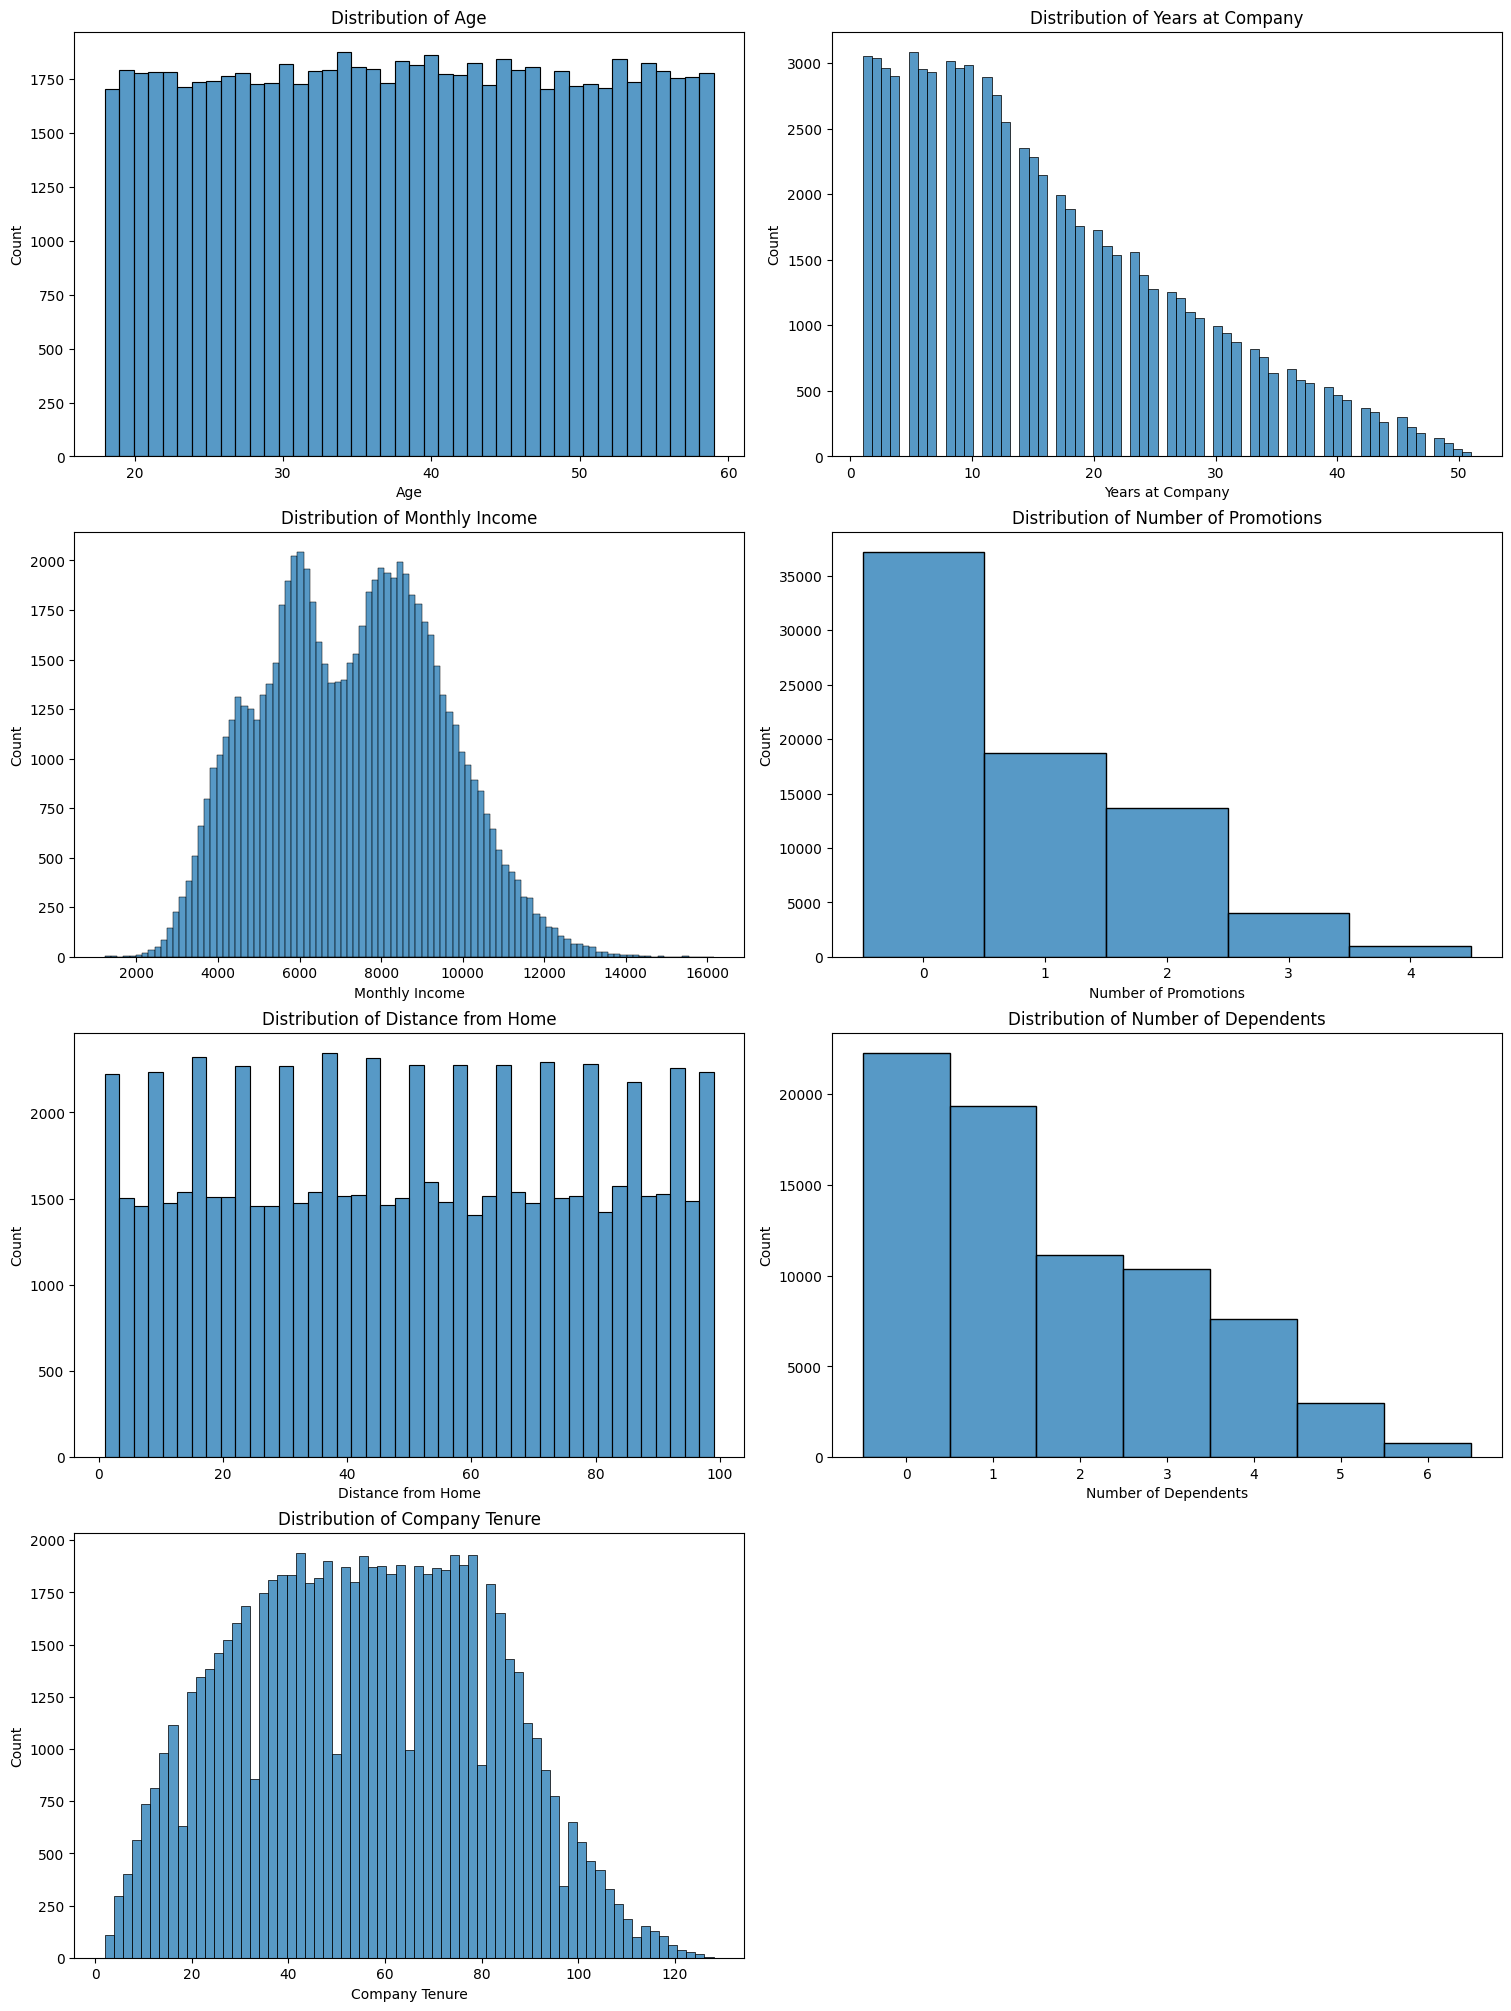

In [118]:
quantitative_vars = ['Age', 'Years at Company', 'Monthly Income', 
                     'Number of Promotions','Distance from Home' ,'Number of Dependents', 'Company Tenure']
num_distribution(data,quantitative_vars)

**Category count**

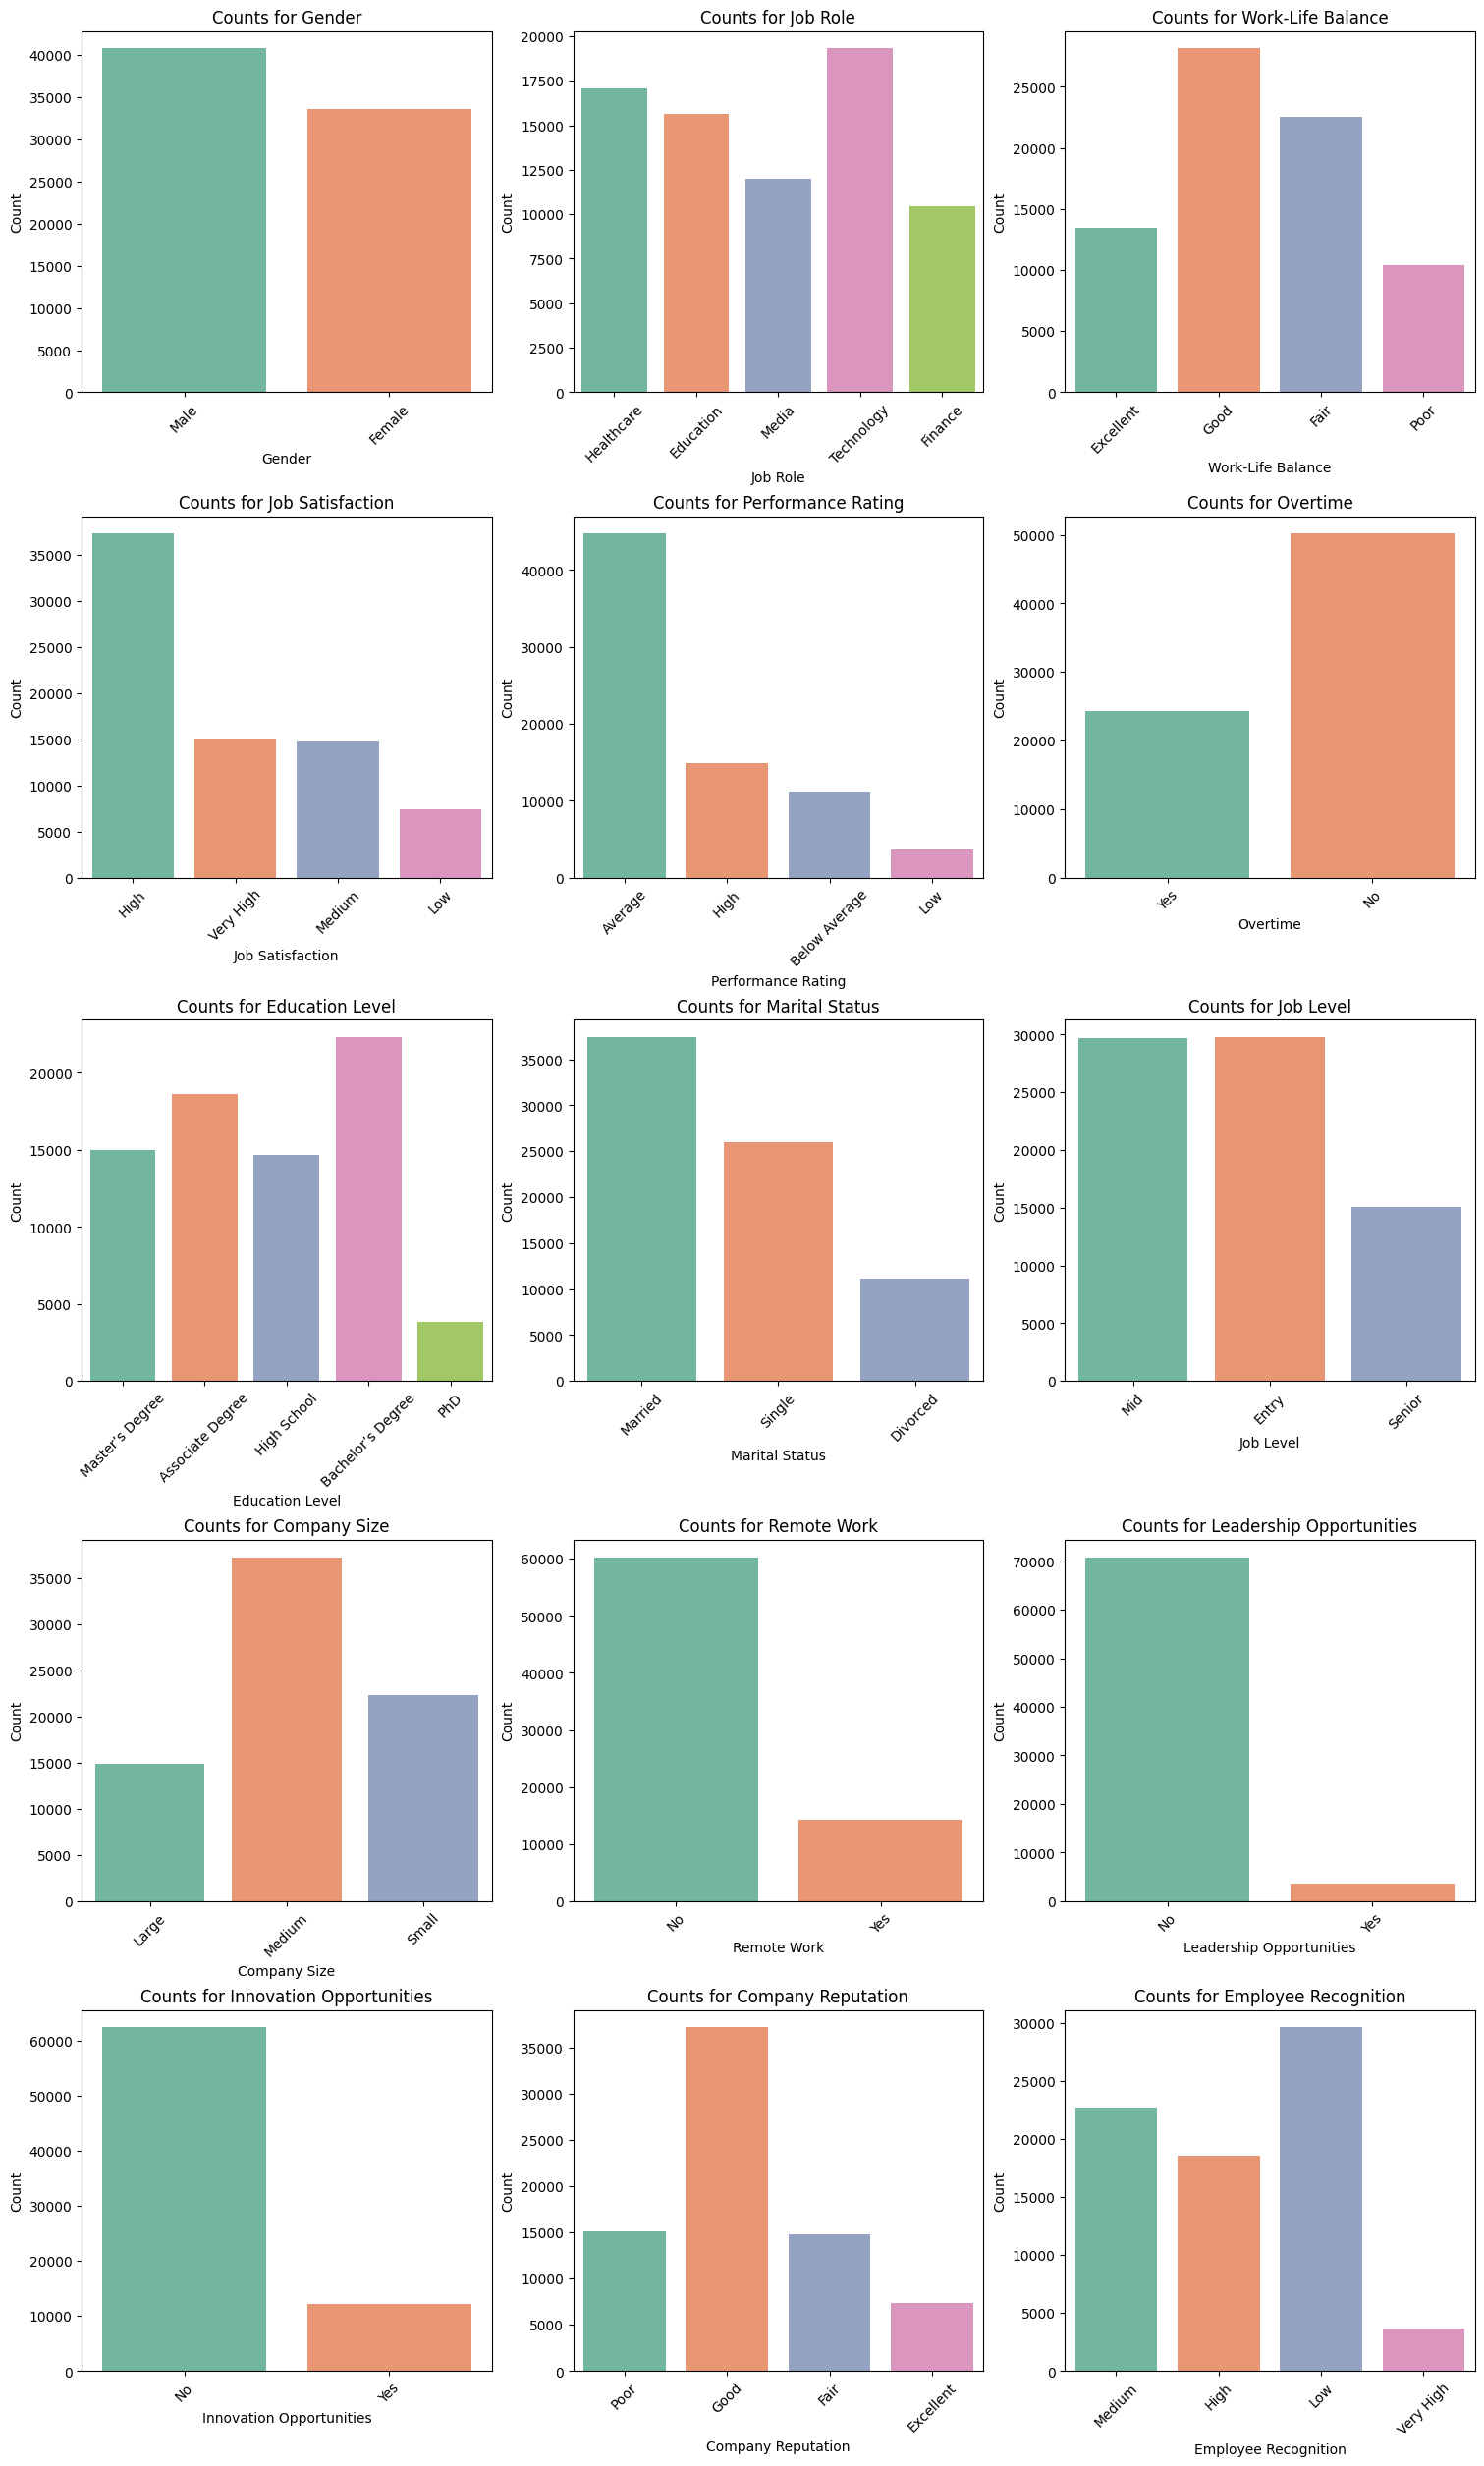

In [119]:
categorical_vars = ['Gender','Job Role','Work-Life Balance','Job Satisfaction', 
                    'Performance Rating','Overtime','Education Level','Marital Status',
                    'Job Level','Company Size','Remote Work','Leadership Opportunities',
                    'Innovation Opportunities', 'Company Reputation','Employee Recognition']
cat_counts(data,categorical_vars)

### Outliers

The data will be examined for outliers in a multivariate sense using the Isolation Forest algorithm.

`Isolation Forest` is an unsupervised machine learning algorithm for anomaly detection, which isolates outliers by recursively partitioning data points using random splits.

**Distributions after removing outliers**

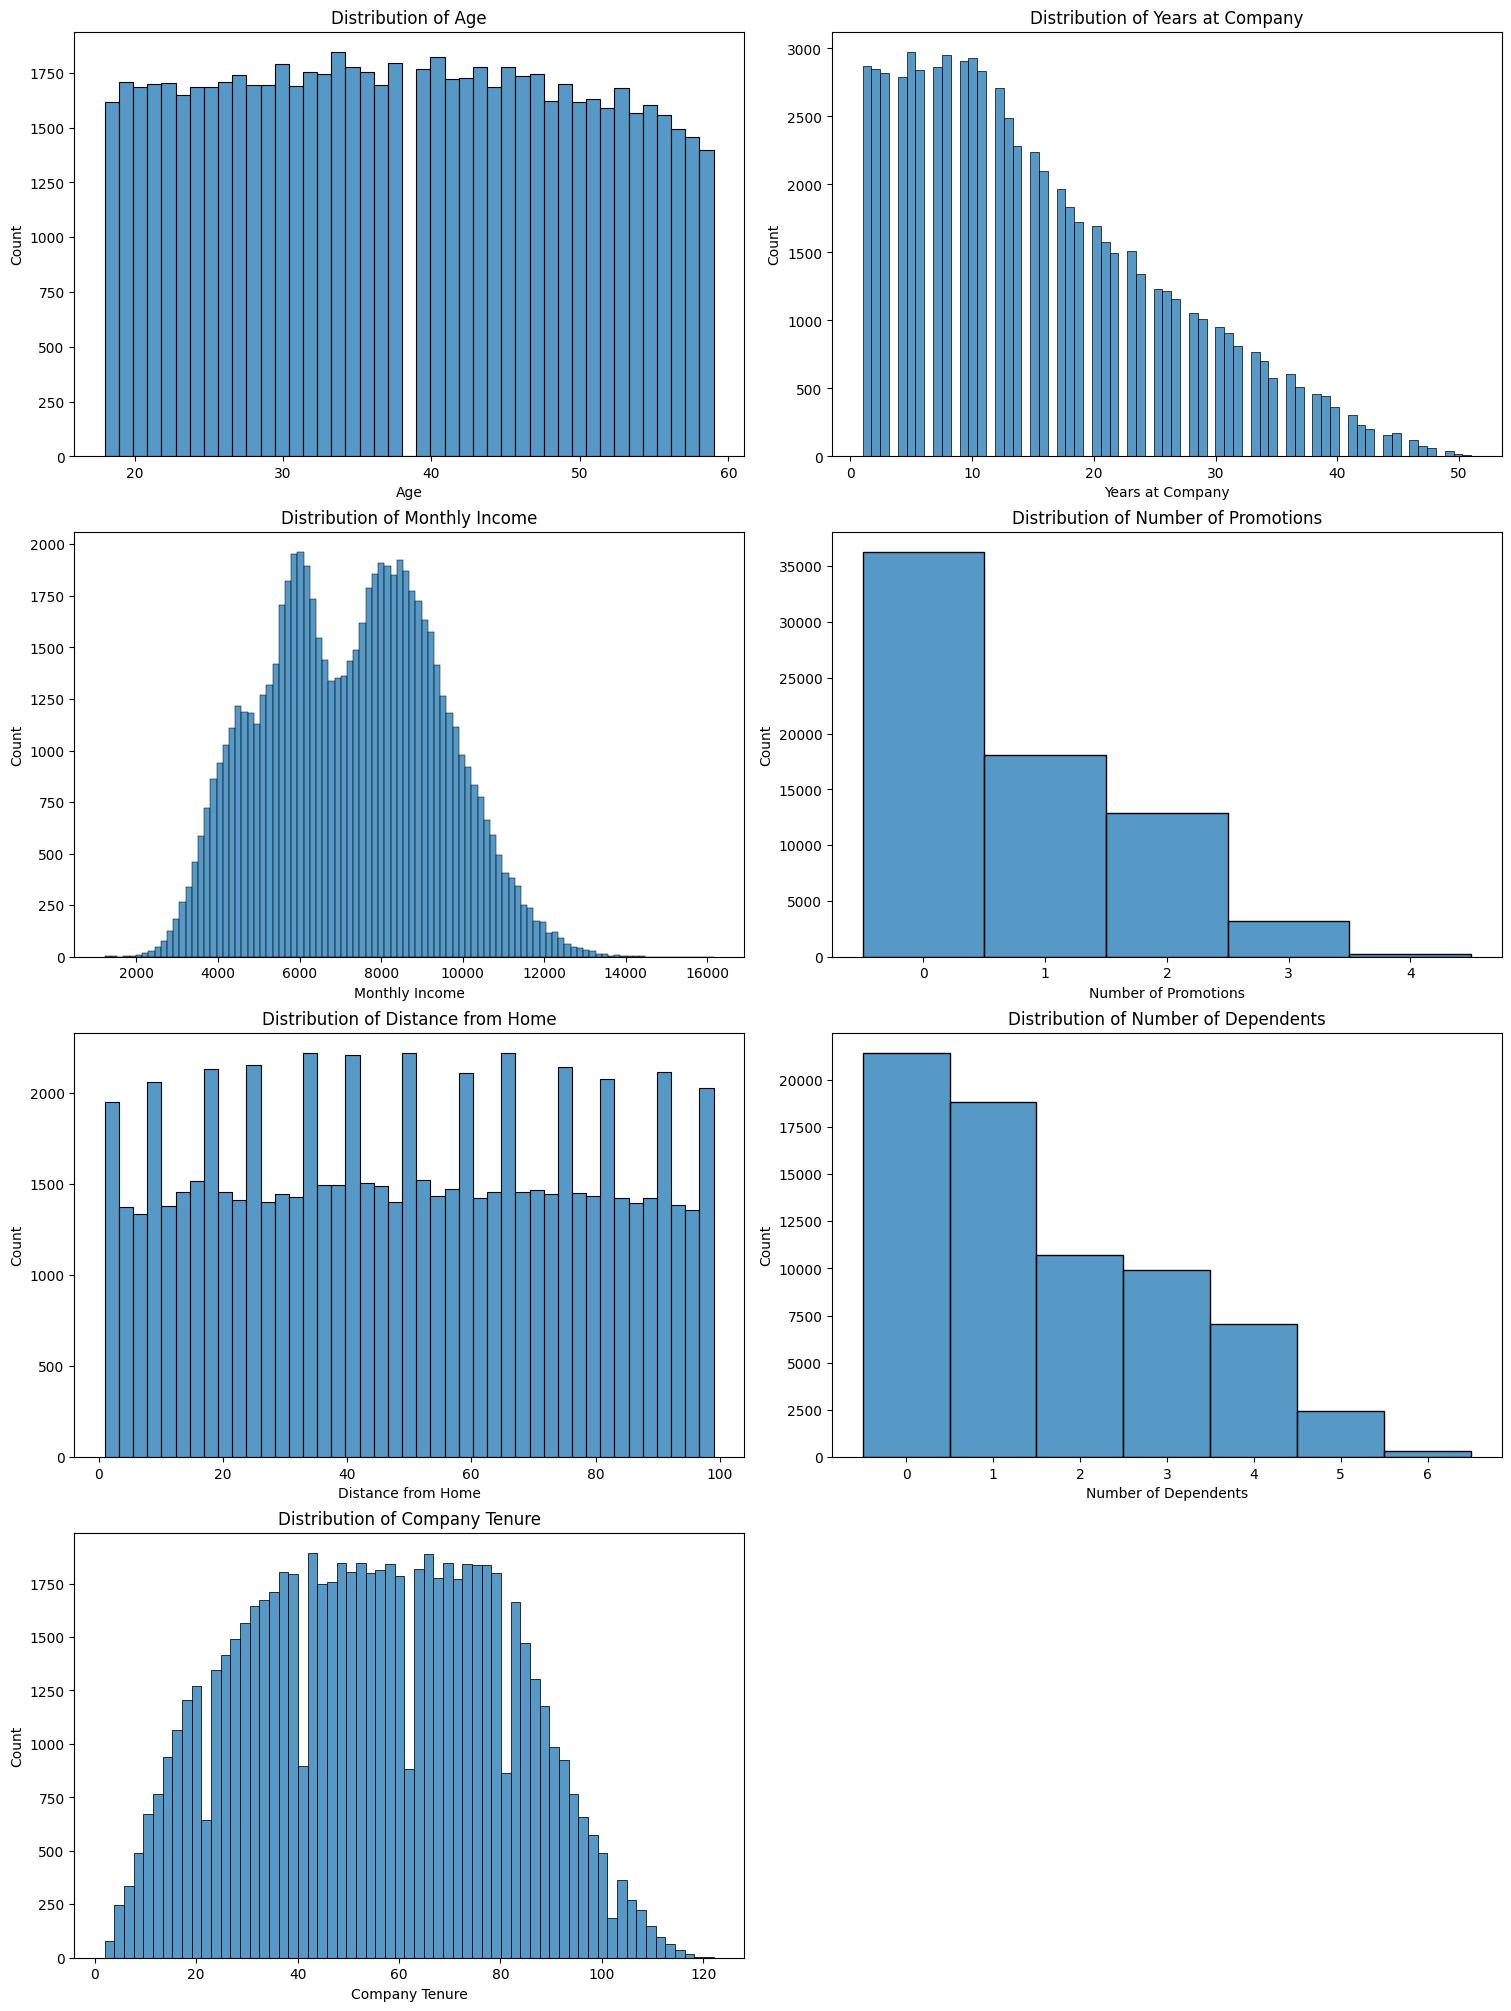

In [120]:
data_cleaned = remove_outliers_from_numerical(data,quantitative_vars,0.05)
num_distribution(data_cleaned,quantitative_vars)

### Influence on Y variable

The impact of variables X on variable Y was analyzed, and significant variables were identified.

**Numerical**

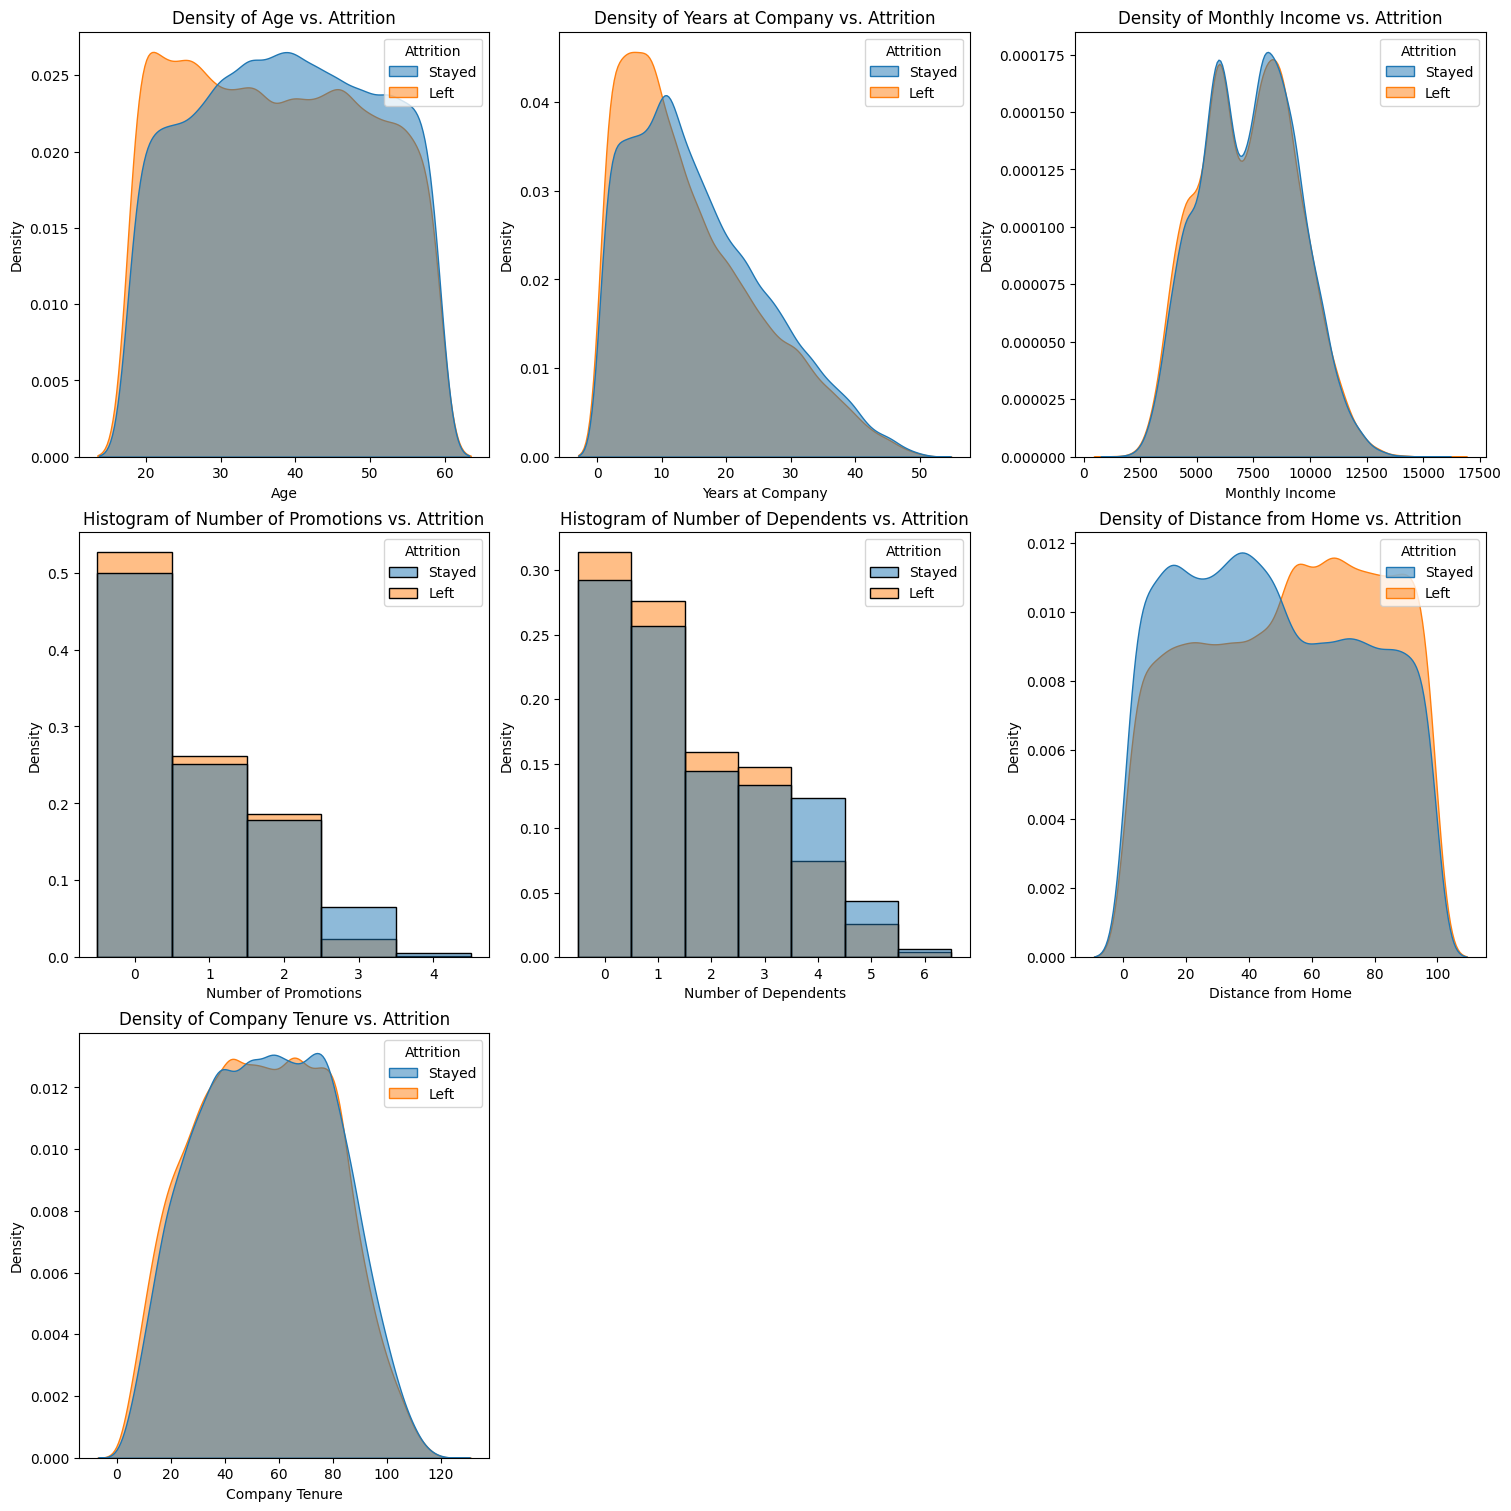

In [121]:
quantitative_vars = ['Age', 'Years at Company', 'Monthly Income', 
                     'Number of Promotions',  'Number of Dependents','Distance from Home', 'Company Tenure']

num_density(data_cleaned,quantitative_vars)

`Monthly Income` and `Company Tenure` do not seem to have an influence on `Attrition`, as their density plots for different categories of Y almost overlap. For these reasons, they will be removed.


**Categorical**

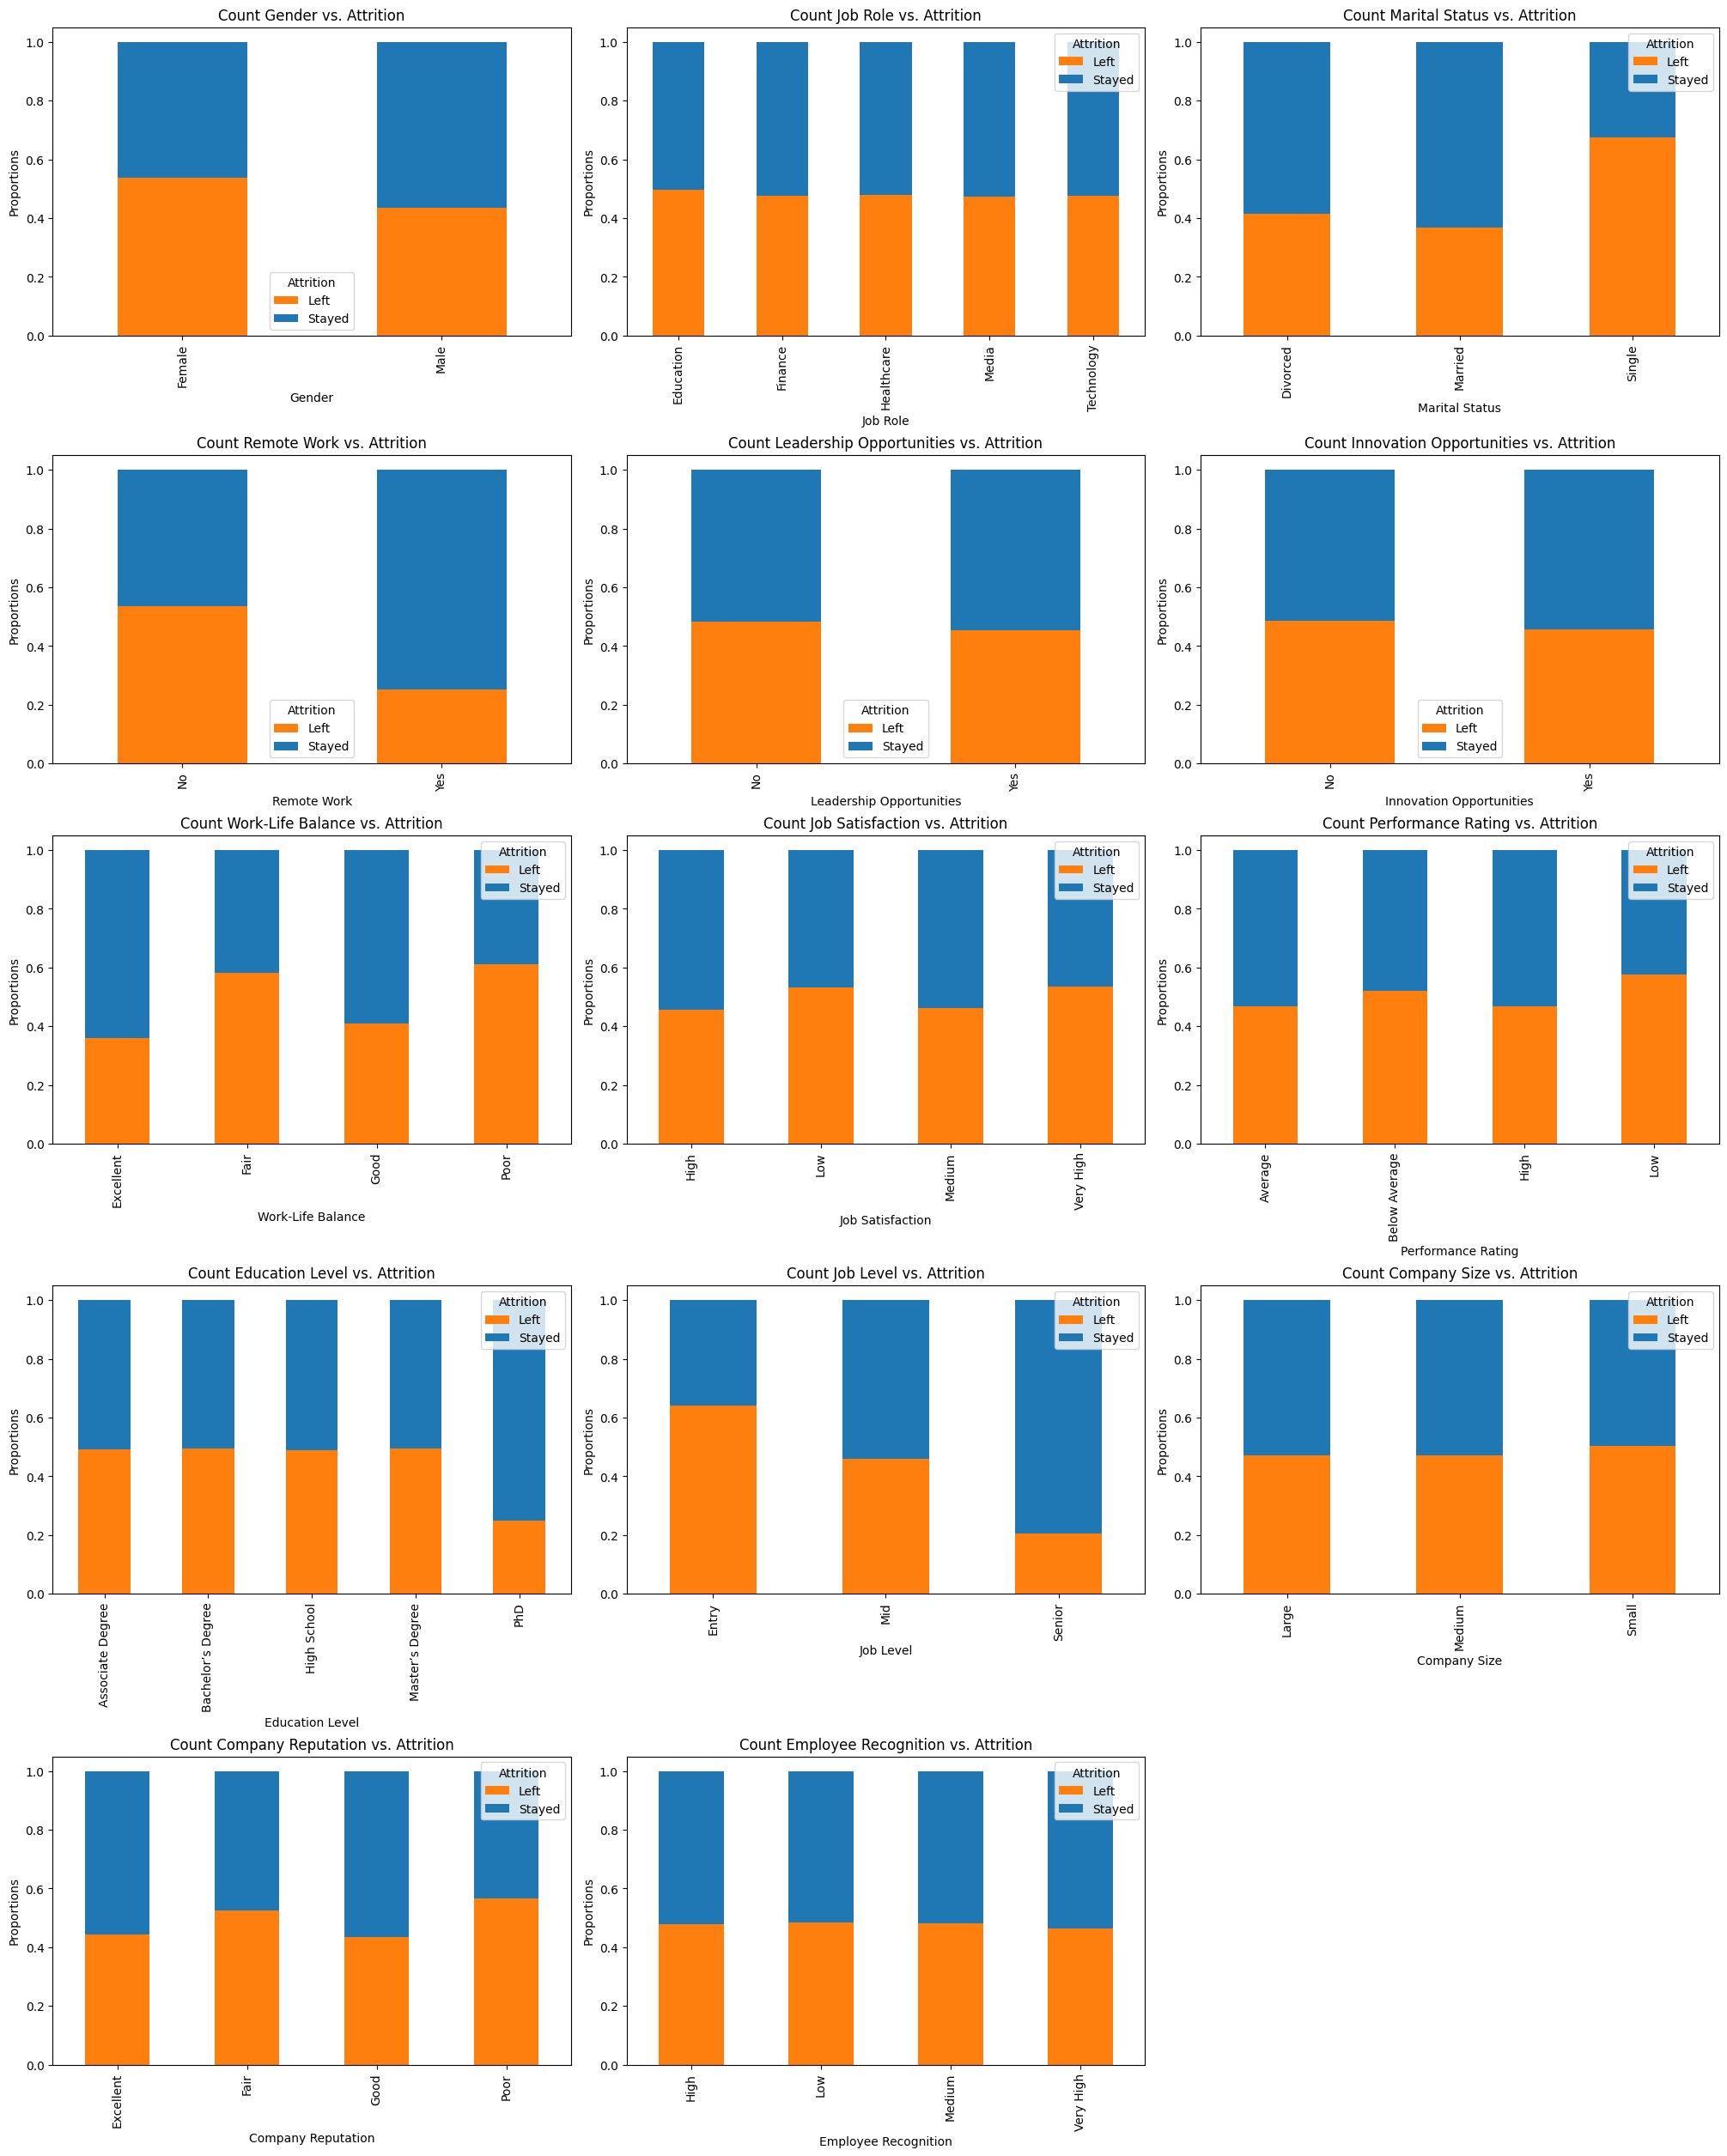

In [122]:

categorical_vars = ['Gender', 'Job Role', 'Marital Status', 'Remote Work', 
                    'Leadership Opportunities', 'Innovation Opportunities', 
                    'Work-Life Balance', 'Job Satisfaction', 'Performance Rating', 
                    'Education Level', 'Job Level', 'Company Size', 
                    'Company Reputation', 'Employee Recognition']

cat_contingency(data_cleaned,categorical_vars)


`Job Role`, `Leadership Opportunities`, `Innovation Opportunities`, `Company Size` and `Employee Recognition` do not seem to have an influence on `Attrition`, as both categories remain within the 0.5 range across all groups in their respective plots.

To reduce complexity of the model:
-`Performance Rating` will be transformed into 2 categories: Positive and Negative
-`Education Level` will be transformed into 2 categories: PhD and Below PhD
-`Company Reputation` will be transformed into 2 categories: High and Low

### Variables - only important

Here is the data after removing non influential variables.

In [123]:
data_cleaned.drop(columns=['Monthly Income', 'Company Tenure', 'Job Role',
                   'Leadership Opportunities', 'Innovation Opportunities', 
                   'Company Size', 'Employee Recognition'], inplace=True)
data_cleaned

,Age,Gender,Years at Company,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,Distance from Home,Education Level,Marital Status,Number of Dependents,Job Level,Remote Work,Company Reputation,Attrition
0,36,Male,13,Excellent,High,Average,1,Yes,83,Master’s Degree,Married,1,Mid,No,Poor,Stayed
1,35,Male,7,Good,High,Average,1,Yes,55,Associate Degree,Single,4,Entry,No,Good,Left
2,50,Male,7,Fair,High,Average,3,Yes,14,Associate Degree,Divorced,2,Senior,No,Good,Stayed
3,58,Male,44,Fair,Very High,High,0,Yes,43,Master’s Degree,Single,4,Entry,No,Poor,Left
4,39,Male,24,Good,High,Average,0,Yes,47,Master’s Degree,Married,6,Mid,Yes,Good,Stayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74493,50,Female,12,Fair,High,Average,1,Yes,66,Bachelor’s Degree,Single,2,Senior,No,Poor,Left
74494,18,Male,4,Fair,High,High,3,No,42,Associate Degree,Single,0,Senior,No,Fair,Left
74495,22,Female,14,Fair,High,High,0,Yes,34,Master’s Degree,Married,2,Entry,No,Good,Stayed
74496,23,Male,8,Fair,Very High,Average,0,No,62,Bachelor’s Degree,Single,0,Entry,No,Good,Left


### Balance

In [124]:
left = int(data_cleaned['Attrition'].eq('Left').sum())
balance = round(left/data_cleaned.shape[0],2)*100
balance

48.0

Data is pretty balanced, so there is no need for under/over sampling. 

## Models

### Preparing data

Ordinal variables

In [125]:
encoder = OrdinalEncoder(categories=[
    ["Poor","Fair", "Good", "Excellent"],     
    ["Low", "Medium","High", "Very High"],       
    ["Low", "Below Average","Average", "High"],         
    ["High School","Associate Degree", "Bachelor’s Degree","Master’s Degree", "PhD"],
    ["Entry", "Mid","Senior"],
    ["Poor","Fair", "Good", "Excellent"] 
])

ordinal_col = ["Work-Life Balance","Job Satisfaction","Performance Rating","Education Level","Job Level","Company Reputation"]
data_cleaned[ordinal_col] = encoder.fit_transform(data_cleaned[ordinal_col])

Binary variables

In [126]:
data_cleaned["Gender"] = data_cleaned["Gender"].map({"Male": 1, "Female": 0})
data_cleaned["Overtime"] = data_cleaned["Overtime"].map({"Yes": 1, "No": 0})
data_cleaned["Remote Work"] = data_cleaned["Remote Work"].map({"Yes": 1, "No": 0})
data_cleaned["Attrition"] = data_cleaned["Attrition"].map({"Left": 1, "Stayed": 0})

Nominal variables - One-Hot Encoding

In [127]:
dummies = pd.get_dummies(data_cleaned["Marital Status"], prefix="Marital_Status", drop_first=True,dtype=int)
data_cleaned = data_cleaned.drop("Marital Status", axis=1)
data_cleaned = pd.concat([data_cleaned.iloc[:, :10], dummies, data_cleaned.iloc[:, 10:]], axis=1)

In [128]:
data_cleaned

,Age,Gender,Years at Company,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,Distance from Home,Education Level,Marital_Status_Married,Marital_Status_Single,Number of Dependents,Job Level,Remote Work,Company Reputation,Attrition
0,36,1,13,3.0,2.0,2.0,1,1,83,3.0,1,0,1,1.0,0,0.0,0
1,35,1,7,2.0,2.0,2.0,1,1,55,1.0,0,1,4,0.0,0,2.0,1
2,50,1,7,1.0,2.0,2.0,3,1,14,1.0,0,0,2,2.0,0,2.0,0
3,58,1,44,1.0,3.0,3.0,0,1,43,3.0,0,1,4,0.0,0,0.0,1
4,39,1,24,2.0,2.0,2.0,0,1,47,3.0,1,0,6,1.0,1,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74493,50,0,12,1.0,2.0,2.0,1,1,66,2.0,0,1,2,2.0,0,0.0,1
74494,18,1,4,1.0,2.0,3.0,3,0,42,1.0,0,1,0,2.0,0,1.0,1
74495,22,0,14,1.0,2.0,3.0,0,1,34,3.0,1,0,2,0.0,0,2.0,0
74496,23,1,8,1.0,3.0,2.0,0,0,62,2.0,0,1,0,0.0,0,2.0,1


### Data division

In [129]:
X = data_cleaned.iloc[:, :-1]
y = data_cleaned.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Random Forest

In [141]:
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt',max_depth=5,max_leaf_nodes=10,min_samples_leaf=100,n_jobs=-1)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)
show_metrics(y_test,y_pred)

[[7199 1904]
 [2908 5683]]
Recall 0.6615062274473286
Specificity: 0.7908381852136658
Accuracy: 0.7280434045439131


**Hyperparameters tuning**

In [131]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [10, 50, 100],  
    'max_depth': [None, 3, 5, 10],   
    'min_samples_split': [500, 1000, 5000],   
    'min_samples_leaf': [250, 500, 2500],     
    'max_features': ['sqrt', 'log2'] 
}

custom_scorer = make_scorer(custom_score)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=1, scoring=custom_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)



print("Best Hyperparameters:", grid_search.best_params_)
print("Best metrics:", grid_search.best_score_)

rf_accuracy,rf_specificity,rf_recall = show_metrics(y_test,y_pred,True)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 250, 'min_samples_split': 500, 'n_estimators': 100}
Best metrics: 0.743147316891081
[[7001 2102]
 [2447 6144]]
Recall 0.715167035269468
Specificity: 0.7690871141381962
Accuracy: 0.7429072001808522


**ROC Curve**

AUC: 0.831


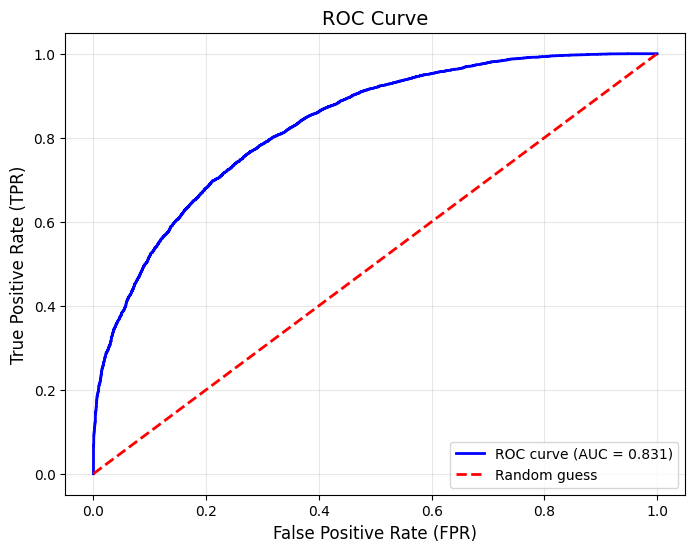

In [132]:
y_proba = best_model.predict_proba(X_test)[:, 1]  
roc_plot(y_test,y_proba)

### Logistic Regression

**Modifying data**

In [133]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

columns_to_scale = ["Age","Years at Company","Distance from Home","Number of Dependents","Number of Promotions"]
scaler = MinMaxScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.fit_transform(X_test[columns_to_scale])

**Correlation matrix**

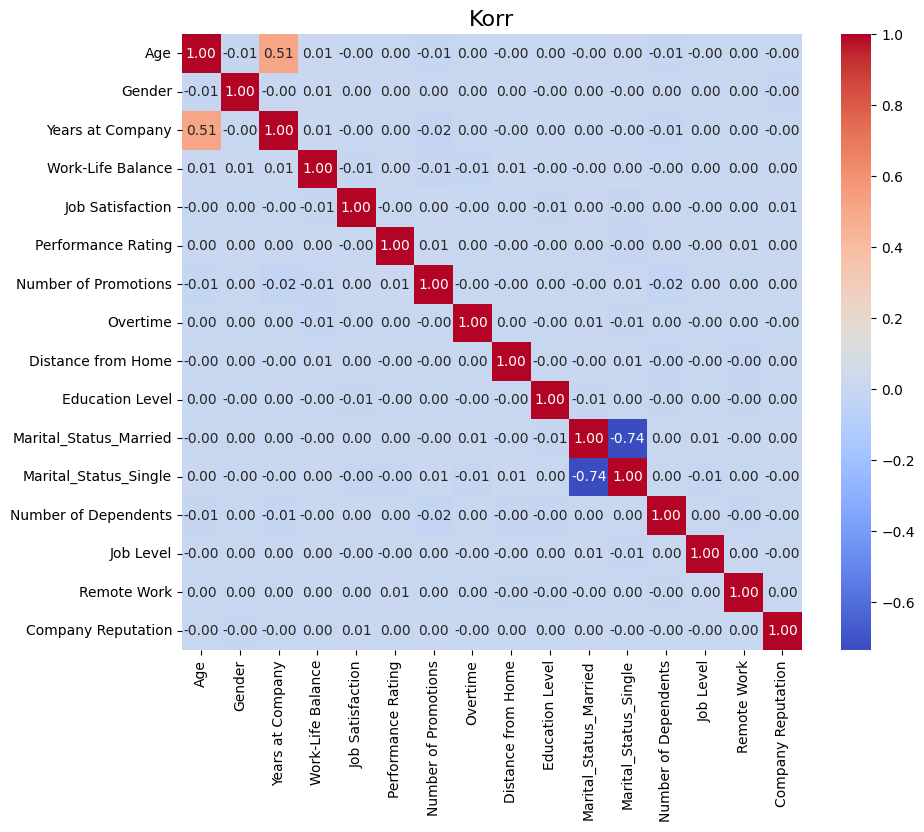

In [134]:
correlation_matrix = data_cleaned.iloc[:, :-1].corr()
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Korr', fontsize=16)
plt.show()

**Training**

In [135]:
log_reg = sm.Logit(y_train,X_train).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.503411
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                53079
Model:                          Logit   Df Residuals:                    53062
Method:                           MLE   Df Model:                           16
Date:                Sun, 12 Jan 2025   Pseudo R-squ.:                  0.2728
Time:                        17:14:23   Log-Likelihood:                -26721.
converged:                       True   LL-Null:                       -36745.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3.1558      0.067     47.176      0.000       3.025      

**Prediction**

In [140]:
y_proba = log_reg.predict(X_test)
y_pred = (y_proba >= 0.5).astype(int)  
l_accuracy,l_specificity,l_recall = show_metrics(y_test,y_pred,True)

[[6903 2200]
 [2406 6185]]
Recall 0.7199394715399837
Specificity: 0.7583214324947819
Accuracy: 0.7396857691872951


**ROC Curve**

AUC: 0.827


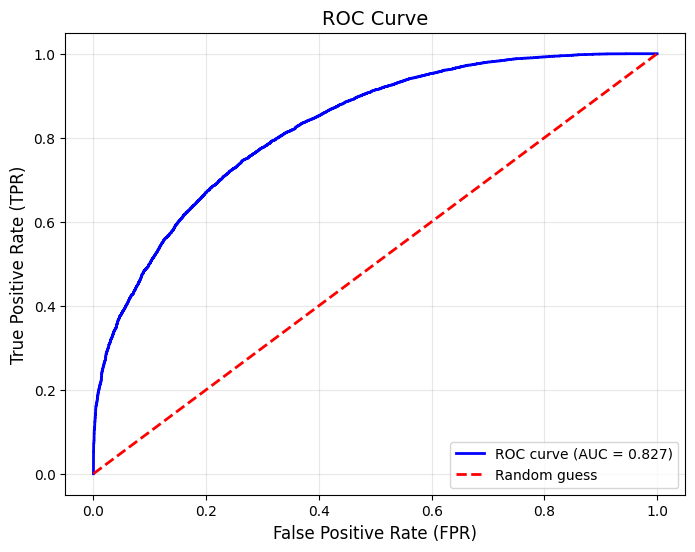

In [137]:
roc_plot(y_test, y_proba)

### SVM

In [159]:
svm = SVC(kernel="poly",gamma="auto",C=1.0,probability=True)
svm.fit(X_train,y_train)
y_proba = svm.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.5).astype(int)
show_metrics(y_test,y_pred)

In [160]:
show_metrics(y_test,y_pred)

[[6827 2276]
 [2219 6372]]
Recall 0.7417064369689209
Specificity: 0.7499725365264198
Accuracy: 0.7459590821747485


In [163]:
svm = SVC(kernel="poly")

param_grid = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto', 0.01, 0.1]
}

custom_scorer = make_scorer(custom_score)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=1, scoring=custom_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)



print("Best Hyperparameters:", grid_search.best_params_)
print("Best metrics:", grid_search.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'C': 1, 'degree': 3, 'gamma': 0.1}
Best metrics: 0.7521587023315914


AUC: 0.836


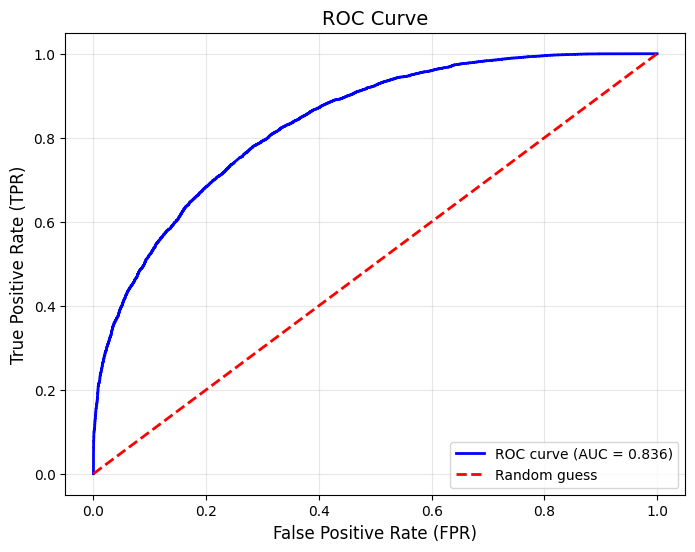

In [161]:
roc_plot(y_test,y_proba)